In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from IPython.core.display import HTML
import datetime
import numpy as np
import numpy.ma as ma
import pickle
import matplotlib.cm as cm

# Load data in

In [2]:
year = 19; w = 543 # w is the mid-season cutoff in stats table

save = os.getcwd()
save = os.path.join(save,"save")
save = os.path.join(save,str(year))

save_bids = os.path.join(save,'allbids.pickle')

with open(save_bids, 'rb') as f:
    df_bids = pickle.load(f)
    
df_bids['Player'] = df_bids['Player'].str.strip()
df_bids['Level'] = df_bids['Level'].astype(int)
df_bids['Round'] = df_bids['Round'].astype(int)
df_bids['Success'] = df_bids['Success'].astype(bool)
    
save_stats = os.path.join(save,'df.pickle')

with open(save_stats, 'rb') as f:
    df_stats = pickle.load(f)

# Prepare for ML

In [3]:
#add points last season to bids table by mapping player names using stats table
points_last_list = df_stats['Points Last Season'].fillna(0).tolist()
name_list = df_stats['Name'].tolist()
name_to_points_last = dict(zip(name_list,points_last_list))
df_bids['Points Last Season'] = df_bids['Player'].map(name_to_points_last)

In [4]:
club_list = df_stats['club'].fillna(0).tolist()
name_list = df_stats['Name'].tolist()
name_to_club_last = dict(zip(name_list,club_list))
df_bids['Club'] = df_bids['Player'].map(name_to_club_last)

In [5]:
df_bids.head()

,Division,Level,Round,Player,Manager,Team,Position,Amount,Success,Points Last Season,Club
0,1,1,1,Alisson,Owen Griffiths,Loko Bakayoko,Goalkeeper,0.0,True,96.0,Liverpool
1,1,1,1,Kepa Arrizabalaga,Andy Carr,Carr Trouble,Goalkeeper,7.5,True,0.0,Chelsea
2,1,1,1,Kepa Arrizabalaga,Matt Davis,Stand Up for the Champion,Goalkeeper,3.0,False,0.0,Chelsea
3,1,1,1,David de Gea,Dave Savery,SmokeCrack Mountain FC,Goalkeeper,7.0,True,36.0,Manchester Utd
4,1,1,1,Ederson,Alex Silverman,Vandelay Industries,Goalkeeper,21.0,True,95.0,Manchester City


In [6]:
# generate one hot encoded values using get_dummies
df_bids_ohe = pd.get_dummies(df_bids, columns=["Club"], prefix=["Club_is"] )
df_bids_ohe = pd.get_dummies(df_bids_ohe, columns=["Position"], prefix=["Position_is"] )

In [7]:
df_bids_ohe = df_bids_ohe._get_numeric_data()
df_bids_ohe.columns

Index(['Level', 'Round', 'Amount', 'Success', 'Points Last Season',
       'Club_is_Arsenal', 'Club_is_Aston Villa', 'Club_is_Bournemouth',
       'Club_is_Brighton & Hove Albion', 'Club_is_Burnley', 'Club_is_Chelsea',
       'Club_is_Crystal Palace', 'Club_is_Everton', 'Club_is_Leicester City',
       'Club_is_Liverpool', 'Club_is_Manchester City',
       'Club_is_Manchester Utd', 'Club_is_Newcastle United',
       'Club_is_Norwich City', 'Club_is_Sheffield United',
       'Club_is_Southampton', 'Club_is_Tottenham', 'Club_is_Watford',
       'Club_is_West Ham United', 'Club_is_Wolverhampton Wanderers',
       'Position_is_Defender', 'Position_is_Forward', 'Position_is_Goalkeeper',
       'Position_is_Midfielder'],
      dtype='object')

In [8]:
X_unscaled = df_bids_ohe.drop(columns='Success')
y_data = df_bids_ohe['Success']

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_data = scaler.fit_transform(X_unscaled)

# Do some ML!

## knn classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [42]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3)

clf = KNeighborsClassifier()
clf.fit(X_train,y_train) 

y_preds = clf.predict(X_test)  
accuracy_score(y_test,y_preds)

0.6809741248097413

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3)

clf2 = LogisticRegression()
clf2.fit(X_train,y_train) 

y_preds2 = clf2.predict(X_test)  
accuracy_score(y_test,y_preds2)

0.6442922374429224

## Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_unscaled, y_data, test_size=0.3)

clf3 = DecisionTreeClassifier(max_depth = 3)
clf3.fit(X_train,y_train) 

y_preds3 = clf3.predict(X_test)  
accuracy_score(y_test,y_preds3)

0.6549467275494673

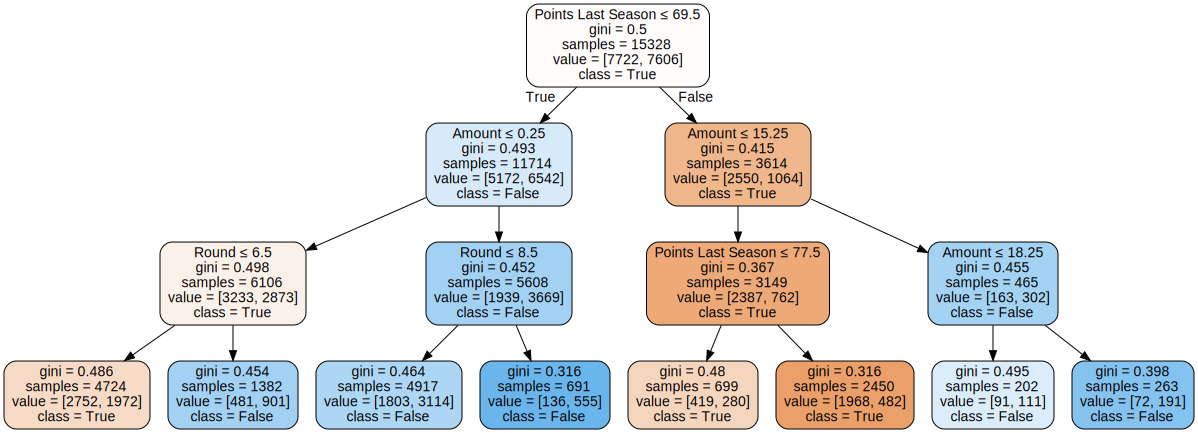

In [67]:
from sklearn.tree import  export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

X_labels = X_unscaled.columns
y_labels = y_data.unique().astype(str)

dot_data = export_graphviz(clf3, out_file=None,
                         filled=True, rounded=True,
                        feature_names = X_labels,
                        class_names = y_labels, 
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Gaussian Naive Bayes

This works badly because one hot encoded variables clearly aren't gauss like

In [50]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3)

clf4 = GaussianNB()
clf4.fit(X_train,y_train) 

y_preds4 = clf4.predict(X_test)  
accuracy_score(y_test,y_preds4)

0.582496194824962

# Stupid approach - Guess all are failures

In [38]:
success_counts = df_bids['Success'].value_counts()
success_counts[0]/success_counts.sum()

0.504292629463878